# **IMPORTING LIBRARIES AND DATA**

In [347]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
import math
from sklearn.metrics import mean_squared_error

In [348]:
df = pd.read_csv('CIPLA.csv')

In [349]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-07-31,405.049988,407.500000,397.549988,400.299988,387.444824,2371558.0
1,2013-08-01,401.850006,408.399994,396.000000,403.350006,390.396881,677074.0
2,2013-08-02,405.100006,405.899994,396.100006,399.899994,387.057709,656648.0
3,2013-08-05,400.000000,401.049988,391.299988,395.750000,383.040985,1054375.0
4,2013-08-06,395.500000,395.500000,387.000000,391.500000,380.852142,2161665.0


## **DATA PREPROCESSING**







In [350]:
for i in range(len(df)):
  if numpy.isnan(df.at[i, 'Open']):
    df.drop(i, axis = 0, inplace = True)

In [351]:
DF = df[['Open', 'High', 'Low', 'Close']]
DF.head()

,Open,High,Low,Close
0,405.049988,407.500000,397.549988,400.299988
1,401.850006,408.399994,396.000000,403.350006
2,405.100006,405.899994,396.100006,399.899994
3,400.000000,401.049988,391.299988,395.750000
4,395.500000,395.500000,387.000000,391.500000


# **NORMALIZING FEATURES**

In [352]:
scale_open = MinMaxScaler(feature_range=(0,1))
scale_rest = MinMaxScaler(feature_range=(0,1))
DF_open = scale_open.fit_transform(numpy.array(DF['Open']).reshape(-1,1))
DF_rest = scale_rest.fit_transform(numpy.array(DF[['High', 'Low', 'Close']]).reshape(-1,3))
DF = numpy.concatenate((DF_open, DF_rest), axis = 1)

# **TRAIN-VALID-TEST SPLIT**

In [353]:
valid_percent = 0.15
test_percent = 0.15
train_percent = 1 - (valid_percent + test_percent)

L = len(DF)

train_size = int(train_percent * L)
valid_size = int(valid_percent * L)
test_size = int(test_percent * L)

train_data = DF[0:train_size,:]
valid_data = DF[train_size:train_size + valid_size, :]
test_data = DF[train_size + valid_size:train_size + valid_size + test_size, :]

In [354]:
def create_inout_sequence(input_data, tw):
  input_seq = []
  input_label = []
  L = len(input_data)
  for i in range(L-tw):
    input_seq.append(input_data[i:i+tw,:])
    input_label.append(input_data[i+tw,0])
    
  return numpy.array(input_seq), numpy.array(input_label)

In [355]:
window = 15
X_train, y_train = create_inout_sequence(train_data, window)
X_valid, y_valid = create_inout_sequence(valid_data, window)
X_test, y_test = create_inout_sequence(test_data, window) 

# **MODEL ARCHITECTURE**

In [ ]:
model=Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, dropout = 0.1, input_shape=(X_train.shape[1],4)))
model.add(LSTM(100, activation='relu', return_sequences=False, dropout = 0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [357]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 15, 100)           42000     
_________________________________________________________________
lstm_32 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 122,501
Trainable params: 122,501
Non-trainable params: 0
_________________________________________________________________


In [358]:
model.fit(X_train, y_train, 32, 50, 1, validation_data=(X_valid, y_valid))

Epoch 1/50
38/38 [==============================] - 2s 54ms/step - loss: 0.0345 - val_loss: 0.0037
Epoch 2/50
38/38 [==============================] - 2s 51ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 3/50
38/38 [==============================] - 2s 50ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 4/50
38/38 [==============================] - 2s 52ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 5/50
38/38 [==============================] - 2s 52ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/50
38/38 [==============================] - 2s 49ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/50
38/38 [==============================] - 2s 50ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 8/50
38/38 [==============================] - 2s 51ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 9/50
38/38 [==============================] - 2s 49ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 10/50
38/38 [==============================] - 2s 49ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 11/

# **ACCURACY AND PLOTTING**

In [359]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
test_predict = model.predict(X_test)

In [360]:
train_predict = scale_open.inverse_transform(train_predict)
y_train = scale_open.inverse_transform(y_train.reshape(-1,1))
valid_predict = scale_open.inverse_transform(valid_predict)
y_valid = scale_open.inverse_transform(y_valid.reshape(-1,1))
test_predict = scale_open.inverse_transform(test_predict)
y_test = scale_open.inverse_transform(y_test.reshape(-1,1))

In [361]:
math.sqrt(mean_squared_error(y_train,train_predict))

23.276807059117065

In [362]:
math.sqrt(mean_squared_error(y_valid,valid_predict))

22.274617066589386

In [363]:
math.sqrt(mean_squared_error(y_test,test_predict))

21.393060773289722

In [364]:
lookback = 15
trainpredict = numpy.empty_like(DF[:,0]).reshape(-1,1)
trainpredict.shape
trainpredict[:,:] = numpy.nan
trainpredict[lookback:train_size, :] = train_predict

In [365]:
validpredict = numpy.empty_like(DF[:,0]).reshape(-1,1)
validpredict[:,:] = numpy.nan
validpredict[train_size + lookback:train_size + valid_size, :] = valid_predict

In [366]:
testpredict = numpy.empty_like(DF[:,0]).reshape(-1,1)
testpredict[:,:] = numpy.nan
testpredict[train_size + valid_size + lookback: -2, :] = test_predict

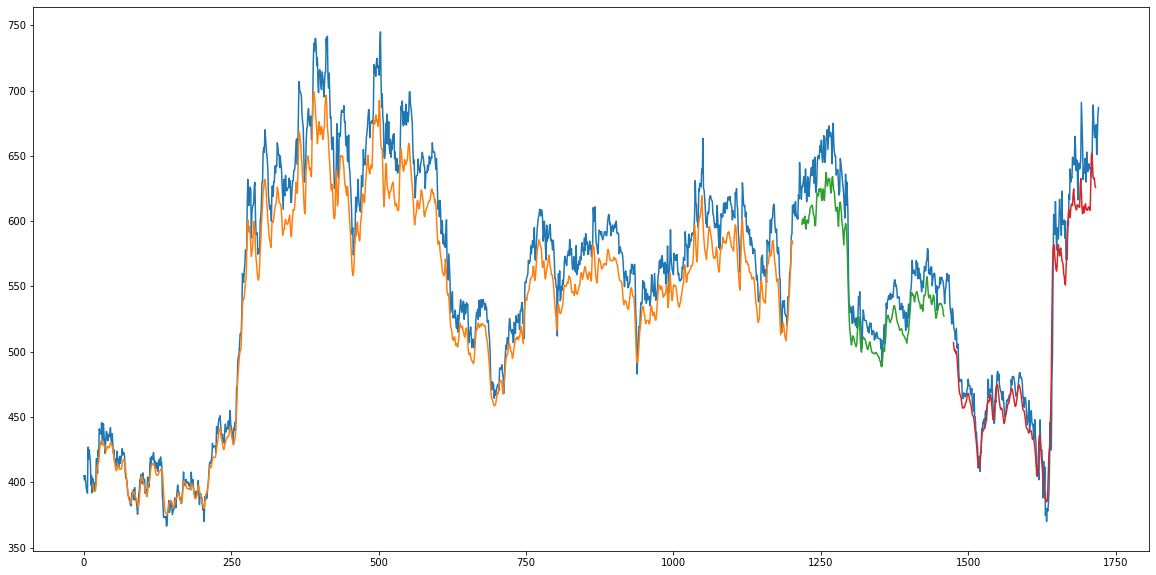

In [367]:
plt.figure(figsize=(20,10))
df['Open'].plot()

plt.plot(trainpredict)
plt.plot(validpredict)
plt.plot(testpredict)